The model will be used for classification of a large dataset with a significant proportion of outliers. A tree based model seems to be a better choice than logistic regression 

In [73]:
# Standard imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# modeling imports
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
# exporting
import pickle
import dataframe_image as dfi

In [74]:
# load dataset
df0 = pd.read_csv(r'C:\Users\max05\OneDrive\Bureau\DATA\_Portfolio\GCC_project\data\interim\HR_cleaned_dataset.csv').drop(columns=['Unnamed: 0'])
df0.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   years_spent_company  work_accident  left  promotion_last_5years department  \
0                    3              0     1                      0      sales   
1                    6              0     1                      0      sales   
2                    4              0     1                      0      sales   
3                    5              0     1                      0      sales   
4                    3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

# Data prep
To classify data it has to be separated into y: the prediction variable and X: the predictor variables.

Then, tree models cannot work with string input so we have to encode the data

In [75]:
y = df0['left']
# drop the prediction variable from X
X = df0.drop(columns=['left'])

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_montly_hours   11991 non-null  int64  
 4   years_spent_company    11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   promotion_last_5years  11991 non-null  int64  
 7   department             11991 non-null  object 
 8   salary                 11991 non-null  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 843.2+ KB


In [77]:
# Encode the salary column into numeric form
X['salary'] = (
            X['salary']
            .astype('category')
            .cat.codes
            )
X['salary'].head()

0    1
1    2
2    2
3    1
4    1
Name: salary, dtype: int8

In [78]:
# Encode the depratment column into several binary column
X = pd.get_dummies(X,drop_first=True)

# Map booleans into ints
X.replace({False:0,True:1},inplace=True)
X.head()

C:\Users\max05\AppData\Local\Temp\ipykernel_8380\831216849.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.replace({False:0,True:1},inplace=True)


satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   years_spent_company  work_accident  promotion_last_5years  salary  \
0                    3              0                      0       1   
1                    6              0                      0       2   
2                    4              0                      0       2   
3                    5              0                      0       1   
4                    3              0                      0       1   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      11991 non-null  float64
 1   last_evaluation         11991 non-null  float64
 2   number_project          11991 non-null  int64  
 3   average_montly_hours    11991 non-null  int64  
 4   years_spent_company     11991 non-null  int64  
 5   work_accident           11991 non-null  int64  
 6   promotion_last_5years   11991 non-null  int64  
 7   salary                  11991 non-null  int8   
 8   department_RandD        11991 non-null  int64  
 9   department_accounting   11991 non-null  int64  
 10  department_hr           11991 non-null  int64  
 11  department_management   11991 non-null  int64  
 12  department_marketing    11991 non-null  int64  
 13  department_product_mng  11991 non-null  int64  
 14  department_sales        11991 non-null

Data is now ready for modeling, everything is numerical

# Model training

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=42)

In [81]:
# Choice of parameters for a random forest model
parameters = {
            'max_depth':[2,3,5,7,10,50,None],
            'min_samples_leaf':[2,10,20,50,200],
            'min_samples_split':[2,3,5,10]
            }

scoring = ['accuracy','precision','recall','f1']

In [82]:
# tree training
decision_tree = DecisionTreeClassifier(random_state=42)

tree = GridSearchCV(decision_tree,
                    parameters,
                    scoring=scoring,
                    cv=5,
                    refit='f1',
                    return_train_score=True
                    )

In [83]:
tree = tree.fit(X_train,y_train)
results = tree.cv_results_

In [84]:
result_df = (
            pd.DataFrame(results)
            [['params','mean_fit_time','mean_test_accuracy','mean_test_recall','mean_test_f1','mean_test_precision']]
            .sort_values('mean_test_f1',ascending=False)
            .head(10)
)
result_df

params  mean_fit_time  \
62  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...       0.009629   
63  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...       0.010131   
60  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...       0.010828   
61  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...       0.011089   
83  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...       0.016073   
80  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...       0.019847   
81  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...       0.013569   
82  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...       0.016290   
67  {'max_depth': 7, 'min_samples_leaf': 10, 'min_...       0.016620   
66  {'max_depth': 7, 'min_samples_leaf': 10, 'min_...       0.012849   

    mean_test_accuracy  mean_test_recall  mean_test_f1  mean_test_precision  
62            0.981413          0.918935      0.942615             0.967643  
63            0.981413          0.916779      0.942476             0.969780  
60            0.981294          0.918218      0.942225             0.967637  
61            0.981294          0.918218      0.942225             0.967637  
83            0.980699          0.916781      0.940386             0.965324  
80            0.980579          0.916067      0.940002             0.965305  
81            0.980579          0.916067      0.940002             0.965305  
82            0.980103          0.916787      0.938664             0.961656  
67            0.979626          0.898845      0.936084             0.976620  
66            0.979626          0.898845      0.936084             0.976620

In [85]:
# Get the 5 best results parameters
result_dict = result_df['params'][:5]
result_dict.to_dict()

{62: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5},
 63: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10},
 60: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2},
 61: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3},
 83: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}}

In [86]:
tree.score(X_test,y_test)

0.947008547008547

# Evaluate model

## Confusion matrix

In [87]:
X_test.shape

(3598, 17)

In [88]:
y_pred = tree.predict(X_test)

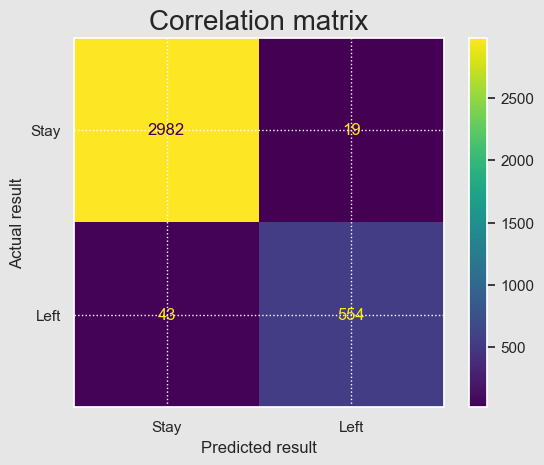

In [89]:
cm = metrics.confusion_matrix(y_test,y_pred,labels=tree.classes_)

sns.set_palette('colorblind')
sns.set(rc={'figure.facecolor':'#e6e6e6'})

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tree.classes_)
disp.plot()

plt.grid(linestyle=':')
plt.title('Correlation matrix', size = 20)
plt.ylabel('Actual result')
plt.xlabel('Predicted result')
plt.xticks([0,1], ['Stay','Left'])
plt.yticks([0,1], ['Stay','Left'])

plt.savefig('../reports/figures/confusion_matrix.png')

In [90]:
print(pd.DataFrame(y_pred)
 .rename(columns={0:'Predicted turn over'})
 )

      Predicted turn over
0                       0
1                       0
2                       0
3                       0
4                       0
...                   ...
3593                    0
3594                    1
3595                    0
3596                    0
3597                    0

[3598 rows x 1 columns]


## Basic evaluation metrics

In [91]:

dfi.export(result_df.head(1).style,'../reports/figures/model_results_table.png')

In [92]:
result_df = result_df.rename(columns={'params':'Chosen parameters for the model',
                                      'mean_fit_time':'Fit time',
                                      'mean_test_accuracy':'Accuracy',
                                      'mean_test_recall':'Recall',
                                      'mean_test_f1':'F1 Score',
                                      'mean_test_precision':'Precision'})

In [93]:
table_of_param = result_df.head(1).style
table_of_param

In [94]:
dfi.export(table_of_param,'../reports/figures/model_results_table.png')

# Model inspection and insights

In [95]:
decision_tree.fit(X_train,y_train)

fig = plt.figure(figsize=(200,200))

plot_tree(decision_tree,max_depth=5,fontsize=60,feature_names=X.columns,class_names={0:'stayed',1:'left'})
plt.show()

In [96]:
gini_df = (
    pd.DataFrame(tree.best_estimator_.feature_importances_,
                 columns=['gini_importance'],
                 index=X.columns
                 )
    .sort_values(by='gini_importance',ascending=False)
)
gini_df

gini_importance
satisfaction_level             0.497745
last_evaluation                0.168132
number_project                 0.131728
years_spent_company            0.127694
average_montly_hours           0.072297
department_technical           0.001505
salary                         0.000760
department_support             0.000138
work_accident                  0.000000
department_RandD               0.000000
promotion_last_5years          0.000000
department_accounting          0.000000
department_hr                  0.000000
department_marketing           0.000000
department_management          0.000000
department_sales               0.000000
department_product_mng         0.000000

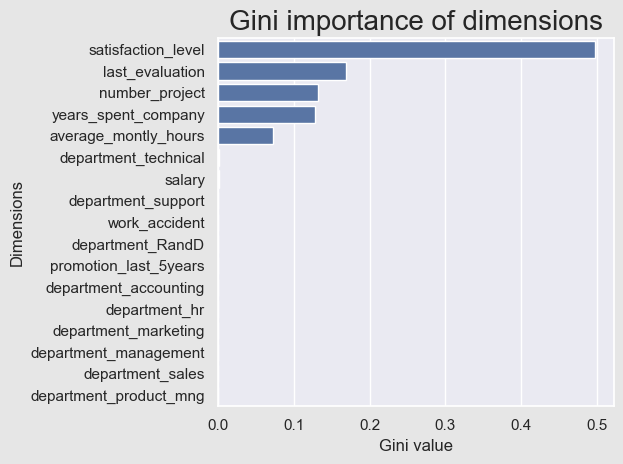

In [97]:
sns.barplot(data=gini_df,x='gini_importance',y=gini_df.index)

plt.title('Gini importance of dimensions', size = 20)
plt.xlabel('Gini value')
plt.ylabel('Dimensions')

plt.tight_layout()
plt.savefig('../reports/figures/gini_importance.png')

# Exporting the model

In [98]:
with open('../models/tree1.pickle','wb') as to_write:
    pickle.dump(tree, to_write)